In [3]:
# Import packages and load the data
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Load the data
df = pd.read_csv('data/incomes.txt',sep=' ', header=None, names=["income"])
df.head()

,income
0,53711.544399
1,99731.233349
2,84773.605417
3,75184.025931
4,73390.955933


<IPython.core.display.Javascript object>


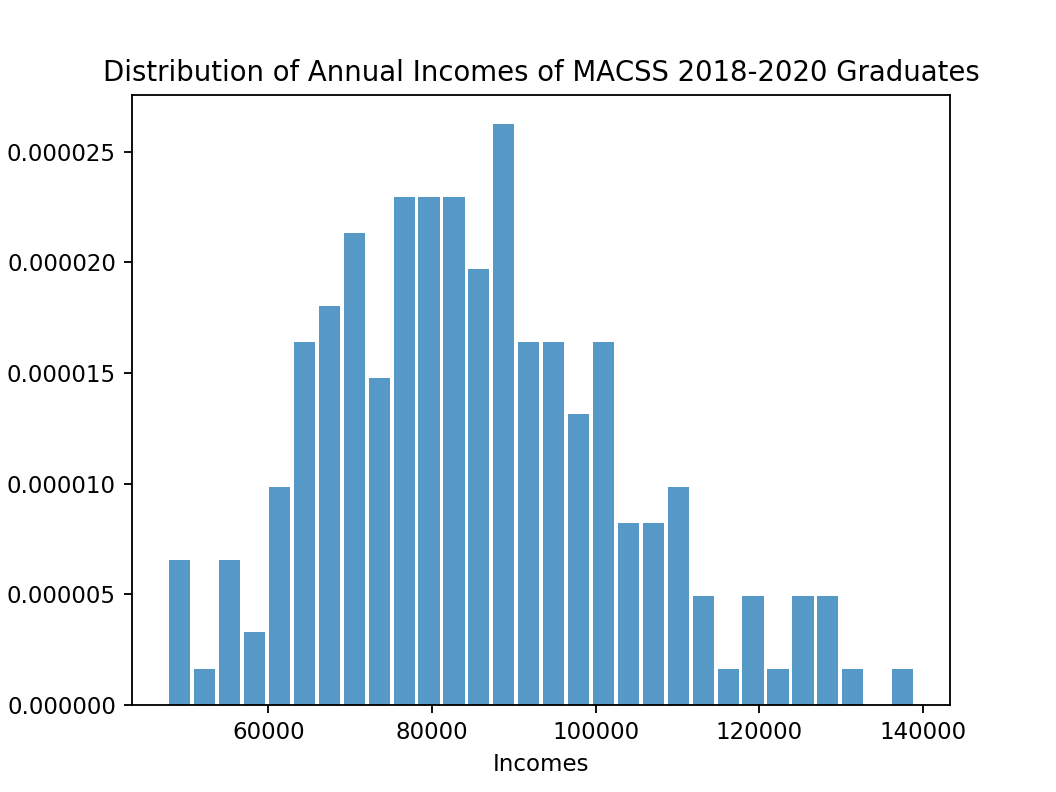

Text(0.5, 1.0, 'Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook
plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,density=True)
plt.xlabel('Incomes')
plt.ylabel('Density')
plt.title('Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

In [5]:
def lognorm_pdf(x, mu, sigma):
    val_pdf = 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*(sigma**2)))
    return val_pdf
def data_moments(x):
    mean_data = x.mean()
    std_data = x.std()
    return mean_data, std_data
def model_moments(mu, sigma):
    mean_model = np.exp(mu+(sigma**2)/2)
    std_model = np.sqrt(np.exp(2*mu+sigma**2)*(np.exp(sigma**2)-1))
    return mean_model, std_model

print(data_moments(df.income))
print(model_moments(11, 3))

(85276.82360625811, 18037.692869371564)
(5389698.476283012, 485135257.4152437)


In [6]:
def err_vec(xvals, mu, sigma, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [7]:
mu_init = 11
sigma_init = 1
params_init = np.array([mu_init, sigma_init])
W_hat = np.eye(2)
gmm_args = (df.income, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
val_crit_1 = results.fun
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1)
mean_data, std_data = data_moments(df.income)
results

      fun: array([[9.47259487e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.74508287e-11, 1.29598548e-10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 19
   status: 0
  success: True
        x: array([11.33177379,  0.20920908])

Mu_GMM1 = 11.331773789265345, sigma_GMM1 = 0.20920907723640728
The value of the GMM criterion function at the estimated parameter values is [[9.47259487e-16]]
Mean of model = 85276.82498788908, standard deviation of model = 18037.692397361345
Mean of data = 85276.82360625811, standard deviation of data = 18037.692869371564


<IPython.core.display.Javascript object>


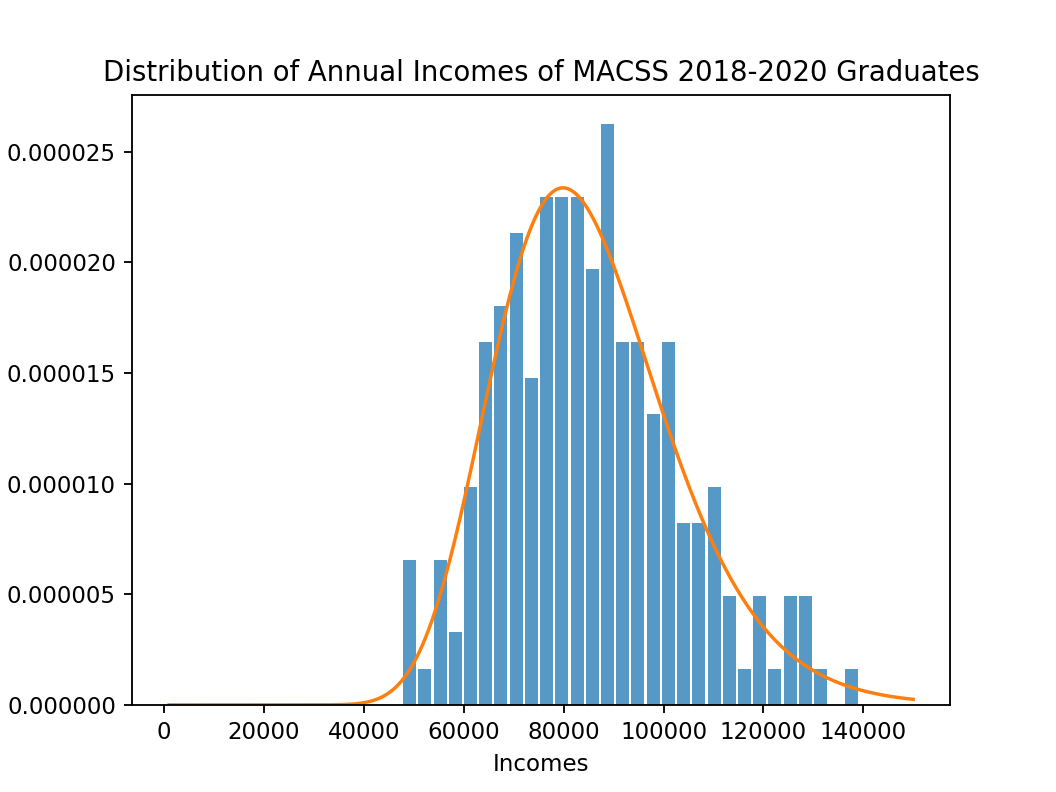

Text(0.5, 1.0, 'Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

In [8]:
print('Mu_GMM1 = {}, sigma_GMM1 = {}'.format(mu_GMM1, sig_GMM1))
print('The value of the GMM criterion function at the estimated parameter values is {}'.format(val_crit_1))
print('Mean of model = {}, standard deviation of model = {}'.format(mean_model, std_model))
print('Mean of data = {}, standard deviation of data = {}'.format(mean_data, std_data))
%matplotlib notebook
plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,density=True)
x = np.linspace(1000, 150000, 1000)
y = lognorm_pdf(x, mu_GMM1, sig_GMM1)
plt.plot(x, y, label='mu=11.36, sigma=0.22')
plt.xlabel('Incomes')
plt.ylabel('Density')
plt.title('Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

#### Part(c)

In [53]:
def get_Err_mat2(x, mu, sigma, simple=False):
    R = 2
    N = len(x)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = x - mean_model
        Err_mat[1, :] = np.sqrt((mean_data - x) ** 2) - std_model
    else:
        Err_mat[0, :] = (x - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - x) ** 2) - std_model) / std_model
    
    return Err_mat

Err_mat = get_Err_mat2(df.income, mu_GMM1, sig_GMM1, False)
#omega
VCV2 = (1 / df['income'].shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
#W two-step
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.04451671 0.0271726 ]
 [0.0271726  0.40492074]]
[[23.42290045 -1.57181667]
 [-1.57181667  2.57509743]]


In [54]:
params_init = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (df.income, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
val_crit_2 = results.fun
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2)
print('Mu_GMM2 = {}, sigma_GMM2 = {}'.format(mu_GMM2, sig_GMM2))
print('Mean of model = {}, standard deviation of model = {}'.format(mean_model, std_model))
print('Mean of data = {}, standard deviation of data = {}'.format(mean_data, std_data))
print('The value of your GMM criterion function at the estimated parameter values is {}'.format(val_crit_2))

Mu_GMM2 = 11.331773789265345, sigma_GMM2 = 0.20920907723640728
Mean of model = 85276.82498788908, standard deviation of model = 18037.692397361345
Mean of data = 85276.82360625811, standard deviation of data = 18037.692869371564
The value of your GMM criterion function at the estimated parameter values is [[9.24453772e-15]]


<IPython.core.display.Javascript object>


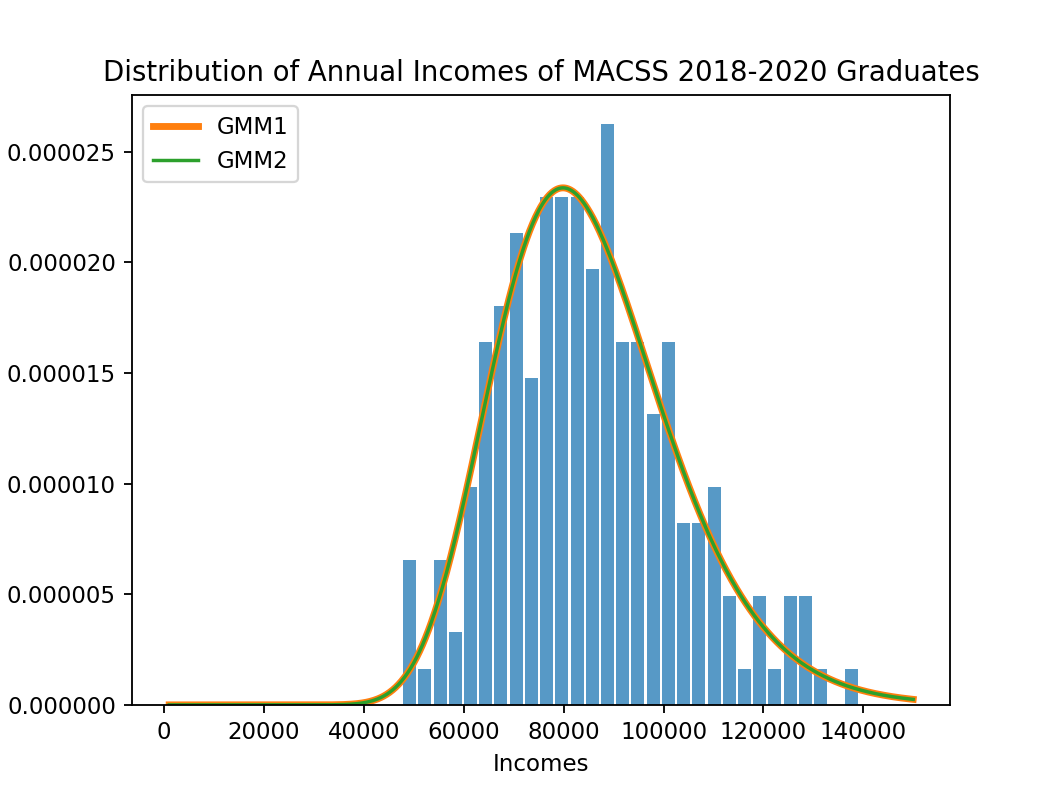

Text(0.5, 1.0, 'Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

In [55]:
plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,density=True)
x = np.linspace(1000, 150000, 1000)
y1 = lognorm_pdf(x, mu_GMM1, sig_GMM1)
y2 = lognorm_pdf(x, mu_GMM2, sig_GMM2)
plt.plot(x, y1, label='GMM1', linewidth=3)
plt.plot(x, y2, label='GMM2')
plt.xlabel('Incomes')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.title('Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

#### Part(d)

In [18]:
def data_moments3(xvals):
    N = len(xvals)
    #percent of individuals who earn less than $75,000
    #percent of individuals who earn between $75,000 and $100,000
    #percent of individuals who earn more than $100,000
    bpct_1_dat = np.sum(xvals<75000)/N
    bpct_2_dat = np.sum((xvals>=75000)&(xvals<=100000))/N
    bpct_3_dat = np.sum(xvals>100000)/N
    return bpct_1_dat, bpct_2_dat, bpct_3_dat
data_moments3(df.income)

(0.3, 0.5, 0.2)

In [20]:
def model_moments3(mu, sigma):
    dfx = lambda x: lognorm_pdf(x, mu, sigma)
    bpct_1_mod = intgr.quad(dfx, 0, 75000)[0]
    bpct_2_mod = intgr.quad(dfx, 75000, 100000)[0]
    bpct_3_mod = intgr.quad(dfx, 100000, np.inf)[0]
    return bpct_1_mod, bpct_2_mod, bpct_3_mod
model_moments3(11.5,0.5)

(0.29132664906842715, 0.2189852313386782, 0.48968607082993554)

In [21]:
def err_vec3(xvals, mu, sigma, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [22]:
mu_init = 11
sig_init = 1
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (df.income, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
val_crit_3 = results_3.fun
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
print('Data moments: ', data_moments3(df.income))
print('Model moments: ', model_moments3(mu_GMM1_3, sig_GMM1_3))
print('Value of the criterion function', val_crit_3)
#results_3

mu_GMM1_3= 11.335681275914704  sig_GMM1_3= 0.21059846666322476
Data moments:  (0.3, 0.5, 0.2)
Model moments:  (0.30000009987975756, 0.4999999636024728, 0.19999993651776996)
Value of the criterion function [[2.16893025e-13]]


#### Part(e)

In [28]:
def get_Err_mat3(pts, mu, sigma, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod)/pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod)/pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod)/pct_3_mod
    
    return Err_mat

Err_mat3 = get_Err_mat3(df.income, mu_GMM1_3, sig_GMM1_3, True)
VCV2_3 = (1 / df['income'].shape[0]) * (Err_mat3 @ Err_mat3.T)
print(VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print(W_hat2_3)

[[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
[[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [29]:
mu_init = 11
sig_init = 1
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (df.income, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
val_crit_4 = results2_3.fun
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
print('Data moments: ', data_moments3(df.income))
print('Model moments: ', model_moments3(mu_GMM2_3, sig_GMM2_3))
print('Value of the criterion function', val_crit_4)
#results2_3

mu_GMM2_3= 11.335681319141559  sig_GMM2_3= 0.21059847593243278
Data moments:  (0.3, 0.5, 0.2)
Model moments:  (0.30000003653834906, 0.4999999591091025, 0.20000000435254872)
Value of the criterion function [[5.51075101e-14]]


<IPython.core.display.Javascript object>


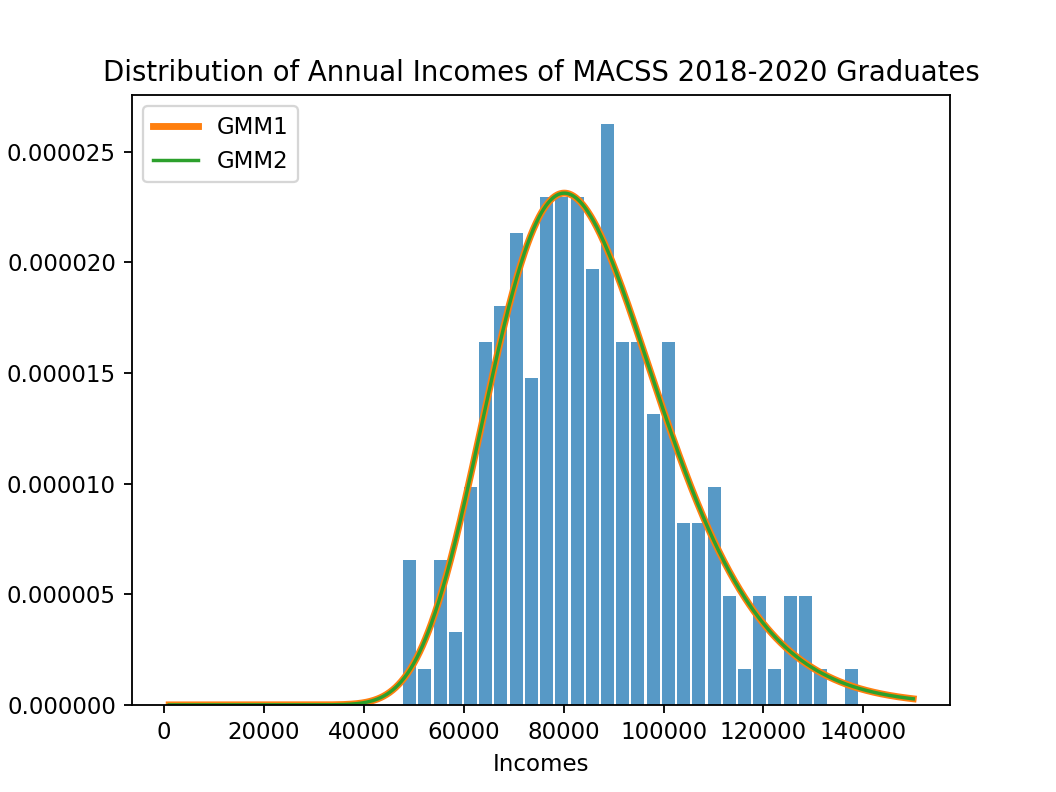

Text(0.5, 1.0, 'Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

In [30]:
plt.hist(df.income, bins=30, alpha=0.75, rwidth=0.85,density=True)
x = np.linspace(1000, 150000, 1000)
y1 = lognorm_pdf(x, mu_GMM1_3, sig_GMM1_3)
y2 = lognorm_pdf(x, mu_GMM2_3, sig_GMM2_3)
plt.plot(x, y1, label='GMM1', linewidth=3)
plt.plot(x, y2, label='GMM2')
plt.xlabel('Incomes')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.title('Distribution of Annual Incomes of MACSS 2018-2020 Graduates')

#### Part(f)

In [33]:
print(val_crit_1, val_crit_2, val_crit_3, val_crit_4)

[[9.47259487e-16]] [[6.31834989e-15]] [[2.16893025e-13]] [[5.51075101e-14]]


The criterion function values are very close. We proceed to look at the variance of our estimates.

In [60]:
def Jac_err2(xvals, mu, sigma, simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((2, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec(xvals, mu + h_mu, sigma, simple) -
          err_vec(xvals, mu - h_mu, sigma, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec(xvals, mu, sigma + h_sig, simple) -
          err_vec(xvals, mu, sigma - h_sig, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

def Jac_err3(xvals, mu, sigma, simple=False):
    Jac_err = np.zeros((3, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec3(xvals, mu + h_mu, sigma, simple) -
          err_vec3(xvals, mu - h_mu, sigma, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec3(xvals, mu, sigma + h_sig, simple) -
          err_vec3(xvals, mu, sigma - h_sig, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [63]:
N = df['income'].shape[0]
d_err2_1 = Jac_err2(df.income, mu_GMM1, sig_GMM1, False)
W_hat1 = np.eye(2)
SigHat2_1 = (1 / N) * lin.inv(d_err2_1.T @ W_hat1 @ d_err2_1)
#print(d_err2_1)
#print(W_hat1)
#print(SigHat2_1)
print('Std. err. mu_GMM1_hat=', np.sqrt(SigHat2_1[0, 0]), 'Std. err. sig_GMM1_hat=', np.sqrt(SigHat2_1[1, 1]))

d_err2_2 = Jac_err2(df.income, mu_GMM2, sig_GMM2, False)
SigHat2_2 = (1 / N) * lin.inv(d_err2_2.T @ W_hat2 @ d_err2_2)
#print(d_err2_2)
#print(W_hat2)
#print(SigHat2_2)
print('Std. err. mu_GMM2_hat=', np.sqrt(SigHat2_2[0, 0]), 'Std. err. sig_GMM2_hat=', np.sqrt(SigHat2_2[1, 1]))

d_err3_1 = Jac_err3(df.income, mu_GMM1_3, sig_GMM1_3, False)
W_hat1_3 = np.eye(3)
SigHat3_1 = (1 / N) * lin.inv(d_err3_1.T @ W_hat1_3 @ d_err3_1)
print('Std. err. mu_GMM1_3_hat=', np.sqrt(SigHat3_1[0, 0]), 'Std. err. sig_GMM1_3_hat=', np.sqrt(SigHat3_1[1, 1]))

d_err3_2 = Jac_err3(df.income, mu_GMM2_3, sig_GMM2_3, False)
SigHat3_2 = (1 / N) * lin.inv(d_err3_2.T @ W_hat2_3 @ d_err3_2)
print('Std. err. mu_GMM2_3_hat=', np.sqrt(SigHat3_2[0, 0]), 'Std. err. sig_GMM2_3_hat=', np.sqrt(SigHat3_2[1, 1]))


Std. err. mu_GMM1_hat= 0.07380097290363677 Std. err. sig_GMM1_hat= 0.0204696795773806
Std. err. mu_GMM2_hat= 0.015285087401760744 Std. err. sig_GMM2_hat= 0.00909798682231668
Std. err. mu_GMM1_3_hat= 0.00854155651445894 Std. err. sig_GMM1_3_hat= 0.009932412215379804
Std. err. mu_GMM2_3_hat= 0.004501889824338687 Std. err. sig_GMM2_3_hat= 0.006442736162913732


Values of the criterion function at estimated parameters are very close, but the standard deviation of the parameters in Part(e) is the smallest. Therefore we choose (e) as the best fit.

## Question 2

#### Part(a)

In [64]:
#Load the data
text = []
with open('data/sick.txt') as f:
    for line in f:
        text.append(line.rsplit()[0].split(','))
text = np.array(text)
df = pd.DataFrame(text[1:], columns=['sick', 'age', 'children', 'temp_winter']).astype('float64')
df.head()

,sick,age,children,temp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


Moment condition is $E[\epsilon_i|\beta]=0$

In [84]:
def err_vec(y, x1, x2, x3, b0, b1, b2, b3, simple):
    #data moment is y, model moment is beta*X
    betaX = b0 + b1*x1 + b2*x2 + b3*x3
    if simple:
        return betaX-y
    else:
        return (betaX-y)/y
    
def crit(params, *args):
    b0, b1, b2, b3 = params
    y, x1, x2, x3, W = args
    err = err_vec(y, x1, x2, x3, b0, b1, b2, b3, True)
    crit_val = err.T @ W @ err
    return crit_val

In [86]:
params_init = np.array([1, 0, 0, 0])
W_hat = np.eye(200)
gmm_args = (df.sick, df.age, df.children, df.temp_winter, W_hat)
res = opt.minimize(crit, params_init, args=(gmm_args),tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = res.x
val_crit = res.fun
print('beta0 = {}, beta1 = {}, beta2 = {}, beta3 = {}'.format(b0, b1, b2, b3))
print('Value of the GMM criterion function evaluated at the optimal parameter is ', val_crit)

beta0 = 0.2516448637185914, beta1 = 0.012933470968263978, beta2 = 0.40050098467599354, beta3 = -0.009991709714024822
Value of the GMM criterion function evaluated at the optimal parameter is  0.0018212898060803585
